In [1]:
from typing import List
import random

import math
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
class Centroid:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def change_centroid(self, x, y):
        self.x = x
        self.y = y


class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.centroid = None

    def assign_centroid(self, centroid: Centroid):
        self.centroid = centroid

In [3]:
def get_min_max_x_y(points: List[Point]) -> (float, float, float, float):
    min_x = 0.0
    max_x = 0.0
    min_y = 0.0
    max_y = 0.0
    for point in points:
        if min_x > point.x or min_x == 0:
            min_x = point.x
        if max_x < point.x or max_x == 0:
            max_x = point.x
        if min_y > point.y or min_y == 0:
            min_y = point.y
        if max_y < point.y or max_y == 0:
            max_y = point.y
    return min_x, max_x, min_y, max_y


def read_dataset() -> (List[Point], float, float, float, float):
    points = []
    path = "./data/dataset"
    with open(path, "r", encoding='latin-1') as f:
        for line in f.readlines():
            entry = line.split()
            points.append(Point(float(entry[1]) / 10, float(entry[2]) / 100))
    min_x, max_x, min_y, max_y = get_min_max_x_y(points)
    return points, min_x, max_x, min_y, max_y


# place cluster centers ck randomly for all k = 1, ... ,K
def init_cluster_centroids(num_clusters, min_x: float, max_x: float, min_y: float, max_y: float) -> List[Centroid]:
    centroids = [Centroid(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
                 for _ in itertools.repeat(None, num_clusters)]
    return centroids


def get_distance(p: Point, c: Centroid) -> float:
    # euclidean distance
    square_diff_x = pow((p.x - c.x), 2)
    square_diff_y = pow((p.y - c.y), 2)
    accumulated_diff = square_diff_x + square_diff_y
    distance = math.sqrt(accumulated_diff)
    return distance


def find_smallest_distance_to_centroid(p: Point, centroids: List[Centroid]) -> Centroid:
    distances = []
    for centroid in centroids:
        distances.append(get_distance(p, centroid))
    index = distances.index(min(distances))
    return centroids[index]


def initial_assign_points_to_clusters(points: List[Point], centroids: List[Centroid]):
    for p in points:
        p.assign_centroid(find_smallest_distance_to_centroid(p, centroids))


# assign data point xi to nearest cluster center
def assign_points_to_clusters(points: List[Point], centroids: List[Centroid]):
    changes = False
    for p in points:
        nearest_centroid = find_smallest_distance_to_centroid(p, centroids)
        if p.centroid != nearest_centroid:
            changes = True
            p.assign_centroid(nearest_centroid)
    return changes

In [4]:
def init_clusters(k: int) -> (List[Point], List[Centroid]):
    points, min_x, max_x, min_y, max_y = read_dataset()
    centroids = init_cluster_centroids(k, min_x, max_x, min_y, max_y)
    initial_assign_points_to_clusters(points, centroids)
    return points, centroids

In [5]:
def find_new_centroid(points: List[Point]) -> (int, int):
    list_x = []
    list_y = []
    for p in points:
        list_x.append(p.x)
        list_y.append(p.y)

    centroid_x = np.mean(list_x)
    centroid_y = np.mean(list_y)
    return centroid_x, centroid_y


# recompute cluster centers
def recompute_centroids(points: List[Point], centroids: List[Centroid]):
    for centroid in centroids:
        cluster_points = []
        for p in points:
            if p.centroid == centroid:
                cluster_points.append(p)
        if len(cluster_points) > 0:
            x, y = find_new_centroid(cluster_points)
            centroid.change_centroid(x, y)


In [6]:
# reiterate until there are no changes in assignments
def fit_clusters(points: List[Point], centroids: List[Centroid]) -> (List[Point], List[Centroid]):
    changes = True
    max_rounds = 20
    i = 0
    while changes:
        recompute_centroids(points, centroids)
        changes = assign_points_to_clusters(points, centroids)
        i += 1
        if i >= max_rounds:
            changes = False
    print("Needed {} round/s to fit cluster/s".format(i))
    return points, centroids

In [7]:
class Summary:
    def __init__(self, k: int, wss: float, points: List[Point], centroids: List[Centroid]):
        self.k = k
        self.wss = wss
        self.points = points
        self.centroids = centroids
        

def wss_of_a_clusters(points: List[Point], centroid: Centroid) -> float:
    wss_k = 0.0
    for point in points:
        wss_i = get_distance(point, centroid)
        wss_k += wss_i
    return wss_k


def calc_wss_in_clusters(points: List[Point], centroids: List[Centroid]) -> float:
    wss = 0.0
    for centroid in centroids:
        cluster_points = []
        for p in points:
            if p.centroid == centroid:
                cluster_points.append(p)
        wss_k = wss_of_a_clusters(cluster_points, centroid)
        wss += wss_k
    return wss


def eval_k(k: int) -> (float, List[Point], List[Centroid]):
    print("------------ Clusters k: {} ------------".format(k))
    points, centroids = init_clusters(k)
    print("--- Clusters initialized ---")
    fit_clusters(points, centroids)
    print("--- Clusters fitted ---")
    wss = calc_wss_in_clusters(points, centroids)
    return wss, points, centroids


# Determine the best K by computing within-cluster sum of squares
def find_best_k() -> (int, float, List[Point], List[Centroid]):
    k_r = range(1, 10)
    summaries = []
    for k in k_r:
        wss, points, centroids = eval_k(k)
        summaries.append(Summary(k, wss, points, centroids))
    return summaries

In [8]:
# find best k
summaries = find_best_k()

------------ Clusters k: 1 ------------
--- Clusters initialized ---
Needed 1 round/s to fit cluster/s
--- Clusters fitted ---
------------ Clusters k: 2 ------------
--- Clusters initialized ---
Needed 2 round/s to fit cluster/s
--- Clusters fitted ---
------------ Clusters k: 3 ------------
--- Clusters initialized ---
Needed 8 round/s to fit cluster/s
--- Clusters fitted ---
------------ Clusters k: 4 ------------
--- Clusters initialized ---
Needed 17 round/s to fit cluster/s
--- Clusters fitted ---
------------ Clusters k: 5 ------------
--- Clusters initialized ---
Needed 5 round/s to fit cluster/s
--- Clusters fitted ---
------------ Clusters k: 6 ------------
--- Clusters initialized ---
Needed 20 round/s to fit cluster/s
--- Clusters fitted ---
------------ Clusters k: 7 ------------
--- Clusters initialized ---


Needed 15 round/s to fit cluster/s
--- Clusters fitted ---
------------ Clusters k: 8 ------------
--- Clusters initialized ---
Needed 9 round/s to fit cluster/s
--- Clusters fitted ---
------------ Clusters k: 9 ------------
--- Clusters initialized ---
Needed 20 round/s to fit cluster/s
--- Clusters fitted ---


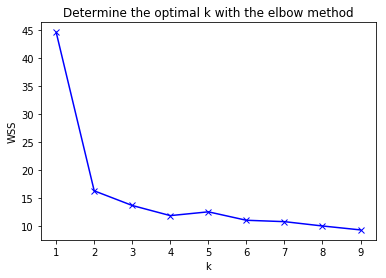

In [9]:
def plot_clusters(summaries: List[Summary]):
    k = []
    wss = []
    for sum in summaries:
        k.append(sum.k)
        wss.append(sum.wss)

    plt.plot(k, wss, 'bx-')
    plt.xlabel('k')
    plt.ylabel('WSS')
    plt.title('Determine the optimal k with the elbow method')
    plt.show()


# plot results
plot_clusters(summaries)